In [1]:
import numpy as np
import pysal as ps
%pylab inline
__author__ = "Serge Rey <sjsrey@gmail.com>"



Populating the interactive namespace from numpy and matplotlib


In [2]:
def squaredDistance(point, segment):
    """Find the squared distance between a point and a segment
    
    Arguments
    =========
    
    point: tuple (x,y)
    
    segment: list of tuples [(x0,y0), (x1,y1)]
    
    Returns
    =======
    
    tuple: 2 elements
    
           distance squared between point and segment
    
           array(xb, yb): the nearest point on the segment
    
    """
    p0,p1 = [np.array(p) for p in segment]
    v = p1 - p0
    p = np.array(point)
    w = p - p0
    c1 = np.dot(w,v)
    if c1 <= 0.:
        # print 'before p0'
        return np.dot(w.T,w), p0
    c2 = np.dot(v,v)
    if c2 <= c1:
        dp1 = p - p1
        # print 'after p1'
        return np.dot(dp1.T,dp1), p1
    
    b = c1 / c2
    bv = np.dot(b,v)
    pb = p0 + bv
    d2 = p - pb
    
    return np.dot(d2,d2), pb
    
    

In [3]:
def snapPointsOnSegments(points, segments):
    """Place points onto closet segment in a set of segments
    
    Arguments
    =========
    
    points: sequence of (x,y) 2-d points
    
    segments: sequence of pysal.cg.shapes.Chain
              Note that the each segment is a chain with *one head and one tail node*, in other words one link only.
              
    Returns
    =======
    
    p2s: dictionary
         key: a point (see points in arguments)
         
         value:  a 2-tuple: ((head, tail), point)
                 where (head, tail) is the target segment, and point is the snapped location on the segment
              
    """
    
    # Put segments in an Rtree
    rt = ps.cg.Rtree()
    SMALL = 0.01
    node2segs = {}
    
    for segment in segments:
        head,tail = segment.vertices
        x0,y0 = head
        x1,y1 = tail
        if (x0,y0) not in node2segs:
            node2segs[(x0,y0)] = []
        if (x1,y1) not in node2segs:
            node2segs[(x1,y1)] = []
        node2segs[(x0,y0)].append(segment)
        node2segs[(x1,y1)].append(segment)
        x0,y0,x1,y1 =  segment.bounding_box
        x0 -= SMALL
        y0 -= SMALL
        x1 += SMALL
        y1 += SMALL
        r = ps.cg.Rect(x0,y0,x1,y1)
        rt.insert(segment, r)
        
        
        
    # Build a KDtree on segment nodes
    kt = ps.cg.KDTree(node2segs.keys())
    p2s = {}
    points.sort()

    for point in points:
        # first find nearest neighbor segment node for point
        dmin, node = kt.query(point, k=1)
        node = tuple(kt.data[node])
        closest = node2segs[node][0].vertices
        
        # use this segment as the candidate closest segment: closest
        # use the distance as the distance to beat: dmin
        p2s[point] = (closest, node) # sna
        x0 = point[0] - dmin
        y0 = point[1] - dmin
        x1 = point[0] + dmin
        y1 = point[1] + dmin
        
        # find all segments with bounding boxes that intersect
        # a query rectangle centered on the point with sides of length 2*dmin
        candidates = [ cand for cand in rt.intersection([x0,y0,x1,y1])]
        dmin += SMALL
        dmin2 = dmin * dmin
        
        # of the candidate segments, find the one that is the minimum distance to the query point
        for candidate in candidates:
            dnc, p2b = squaredDistance(point, candidate.vertices)
            if dnc <= dmin2:
                closest = candidate.vertices
                dmin2 = dnc
                p2s[point] = (closest, p2b)
        
    return p2s
    
    

## Example

In [4]:
eb = ps.open(ps.examples.get_path("eberly_net.shp"))

In [5]:
# note eberly has chain==segment, forall chains. not necessarily true for all chains in polyline shapefiles
# will have to generalize this
segments = [ chain for chain in eb] 

In [6]:
ep = ps.open(ps.examples.get_path("eberly_net_pts_offnetwork.shp"))

In [7]:
points = [ point for point in ep]

(-1, 10)

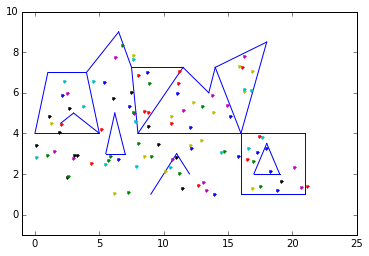

In [8]:
#plotting
network = []
for segment in segments:
    head,tail = segment.vertices
    x1,y1 = head
    x2,y2 = tail
    network.append((x1,x2))
    network.append((y1,y2))
    network.append('b')
plot(*network)
for point in points:
    x,y = point
    plot(x,y, '.')
xlim(-1,25)
ylim(-1,10)

In [9]:
res = snapPointsOnSegments(points, segments)

(-1, 10)

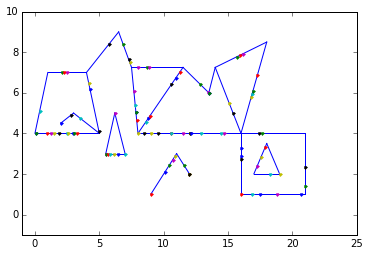

In [10]:
#plotting
network = []
for segment in segments:
    head,tail = segment.vertices
    x1,y1 = head
    x2,y2 = tail
    network.append((x1,x2))
    network.append((y1,y2))
    network.append('b')
plot(*network)
for point in points:
    snapped = res[point]
    x,y = snapped[1]
    #print point,snapped
    plot(x,y, '.')
xlim(-1,25)
ylim(-1,10)

In [11]:
pnts = res.keys()
pnts.sort()
for pnt in pnts:
    print pnt, res[pnt]

(0.08503569102250197, 3.4291679735487035) ([(0.0, 4.0), (5.0, 4.0)], array([ 0.08503569,  4.        ]))
(0.10582418812288263, 2.8529527589939496) ([(0.0, 4.0), (5.0, 4.0)], array([ 0.10582419,  4.        ]))
(0.9221933143848327, 2.932646727847103) ([(0.0, 4.0), (5.0, 4.0)], array([ 0.92219331,  4.        ]))
(1.125205331703149, 4.8587675506025425) ([(1.0, 7.0), (0.0, 4.0)], array([ 0.3701508,  5.1104524]))
(1.2294216099258877, 4.528823930291667) ([(0.0, 4.0), (5.0, 4.0)], array([ 1.22942161,  4.        ]))
(1.5043534922448583, 3.1321032351822966) ([(0.0, 4.0), (5.0, 4.0)], array([ 1.50435349,  4.        ]))
(1.874678044967222, 4.0518996984423055) ([(0.0, 4.0), (5.0, 4.0)], array([ 1.87467804,  4.        ]))
(1.9947115329847633, 4.447281096736115) ([(3.0, 5.0), (2.0, 4.5)], array([ 2. ,  4.5]))
(2.0840557657189747, 5.8651611966484545) ([(1.0, 7.0), (4.0, 7.0)], array([ 2.08405577,  7.        ]))
(2.291937682192724, 6.57834834523361) ([(1.0, 7.0), (4.0, 7.0)], array([ 2.29193768,  7.    